In [4]:
import vof
from vof import forecaster
from vof import optimizer

In [5]:
#pip install altair

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
import sklearn
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed

from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse, mape
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting
# import darts.models
import holidays


plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

,y,Temperature,Day_of_week,Hour_of_day,Holidays,Smoothed_temperature
time,,,,,,
2018-01-01 00:00:00,8.143500,3.50,0,0,1,NaN
2018-01-01 01:00:00,7.789000,3.74,0,1,1,NaN
2018-01-01 02:00:00,7.470750,2.57,0,2,1,NaN
2018-01-01 03:00:00,7.354500,1.96,0,3,1,NaN
2018-01-01 04:00:00,7.374250,1.44,0,4,1,NaN
...,...,...,...,...,...,...
2020-01-01 19:00:00,9.021000,0.19,2,19,1,NaN
2020-01-01 20:00:00,8.912250,0.62,2,20,1,NaN
2020-01-01 21:00:00,9.148667,-2.91,2,21,1,NaN


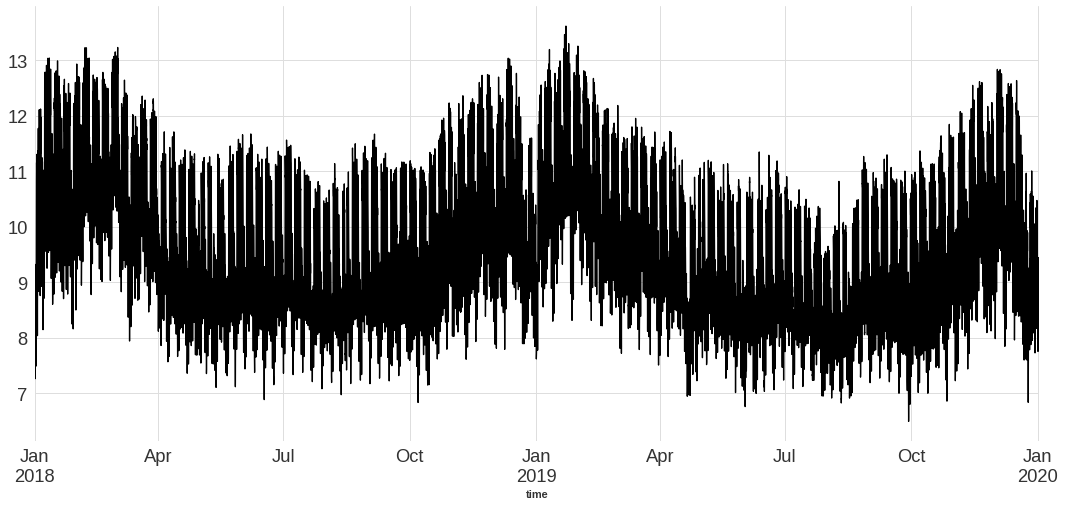

In [7]:
# data = pd.read_parquet('data/Elia/data_load_forecasts.parquet').loc['2019-01-01':'2019-04-25']
data = pd.read_parquet('data/Elia/f4sg.parquet')#.loc['2019-01-01':'2019-04-25']
data = data.reset_index()
# data['time'] = pd.to_datetime(data.time).dt.tz_localize(None)
data['Day_of_week'] = data['time'].dt.dayofweek
data['Hour_of_day'] = data['time'].dt.hour
data = data.set_index('time')
data['Holidays'] = pd.Series(data.index).apply(lambda x: holidays.CountryHoliday('BE').get(x)).values
data['Holidays'] = data['Holidays'].astype('bool').astype('int')
data.columns = ['y','Temperature','Day_of_week','Hour_of_day','Holidays']
data['Smoothed_temperature'] = data.Temperature.rolling(337, center=True).mean()
data.y = data.y/1000
data.y.plot()
data


In [8]:
# data = pd.read_csv("data/district/Actuals.csv", index_col=0, parse_dates=True).loc['2019-01-01':'2019-04-25']
# data.head(5)
# data.columns = ['y','Pressure_kpa','Cloud Cover (%)','Humidity (%)','Temperature (C)','Wind Direction (deg)','Wind Speed (kmh)']
# data.y = data.y/100000

# data.reset_index(inplace=True)
# data['sin_hour'] = np.sin(2*np.pi*data.Time.dt.hour/24)
# data['cos_hour'] = np.cos(2*np.pi*data.Time.dt.hour/24)

# data.set_index('Time', inplace=True)
# data.y.plot()
# data

# Creating forecast from Fact data

## Estimating Lags and adding them to the object

In [9]:
# def estimateSignificantLags(ts, nlags = 360, significantLags = 11): 
#     pacf = sm.tsa.stattools.pacf(ts, nlags)
#     lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
#     plt.plot(pacf,'*--')
#     plt.plot(lags,pacf[lags],'o')
#     return lags

In [10]:
# lags = estimateSignificantLags(data.y, significantLags = 10)
# # add lags for certain days
# lags = np.unique(np.hstack([lags]))
# print(np.sort(lags))

## Now the dataset is ready, so we can start building a dataframe with different predictions for further optimization.
All predictions will be in the same dataframe optimization_df together with the Fact data.
We run several prediction models

In [11]:
input_timeseries = TimeSeries.from_dataframe(data, value_cols=['y'])#[0:-24]
# future = TimeSeries.from_dataframe(data, value_cols=['Pressure_kpa', 'Cloud Cover (%)',
#                                                      'Humidity (%)','Temperature (C)', 
#                                                      'Wind Direction (deg)', 'Wind Speed (kmh)'])
# future = TimeSeries.from_dataframe(data, value_cols=['Temperature (C)', 'sin_hour', 'cos_hour'])
input_timeseries


<TimeSeries (DataArray) (time: 17544, component: 1, sample: 1)>
array([[[8.1435    ]],

       [[7.789     ]],

       [[7.47075   ]],

       ...,

       [[9.14866667]],

       [[9.2915    ]],

       [[8.76833333]]])
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2020-01-01T23:00:00
  * component  (component) object 'y'
Dimensions without coordinates: sample

In [12]:
# We first set aside the first 25% as training series:
input_train, input_test = input_timeseries.split_before(pd.to_datetime('2019-01-01'))

def eval_model(model, past_covariates=None, future_covariates=None, retrain=False):
    
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=pd.to_datetime('2019-01-01'), 
#                                           start=0.33, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=24)
    
    input_timeseries[-len(backtest)-336:].plot()
    backtest.plot(label='Backtest')
    print('Backtest MAPE = {}'.format(mape(input_timeseries, backtest)))
    plt.show()

    error = input_timeseries[-len(backtest):].pd_series() - backtest.pd_series()
    error.rolling(49, center=True).mean().plot()
    plt.show()


  0%|          | 0/8761 [00:00<?, ?it/s]

Backtest MAPE = 4.447783233164784


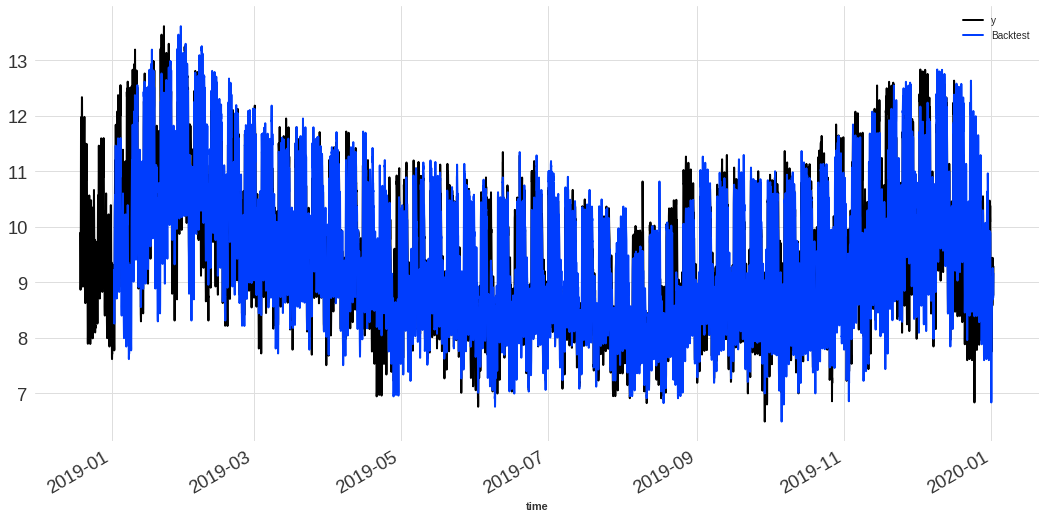

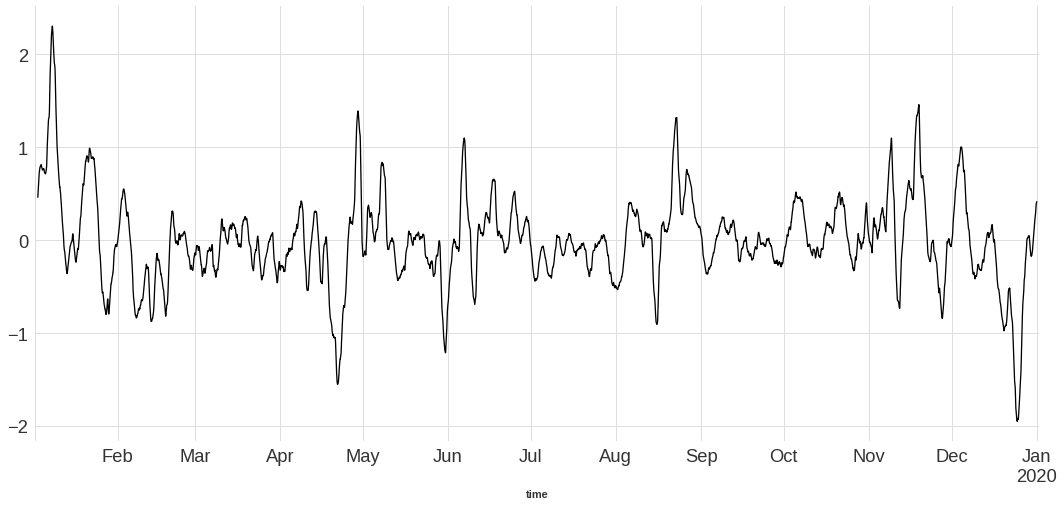

In [13]:
naive_model_weekly = NaiveSeasonal(K=168)
eval_model(naive_model_weekly, retrain=True)


  0%|          | 0/8761 [00:00<?, ?it/s]

Backtest MAPE = 5.939043507268879


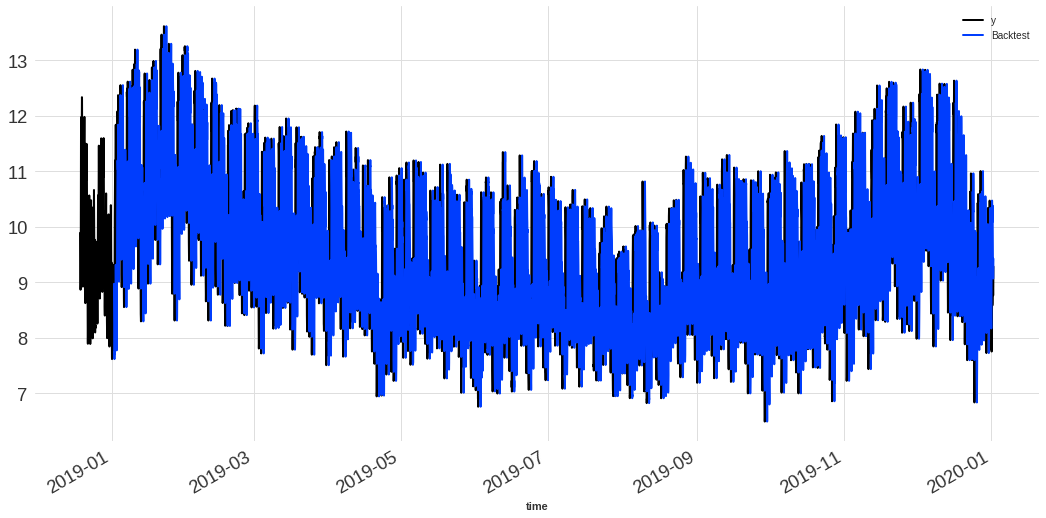

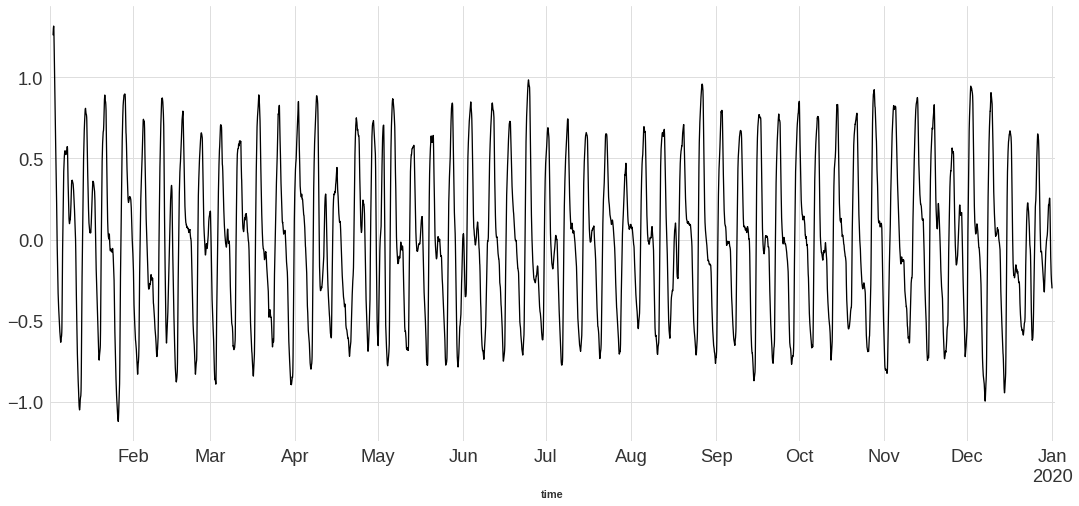

In [14]:
naive_model_daily = NaiveSeasonal(K=24)
eval_model(naive_model_daily, retrain=True)


In [48]:
theta_model = Theta(seasonality_period=168)
# eval_model(theta_model, retrain=True)


In [52]:
regr_model_lags_336 = RegressionModel(lags=list(range(-336,0)))
regr_model_lags_336.fit(input_train)
# eval_model(regr_model_lags_336, retrain=False)


In [53]:
regr_model_lags_168 = RegressionModel(lags=list(range(-168,0)))
regr_model_lags_168.fit(input_train)
# eval_model(regr_model_lags_168, retrain=False)


In [54]:
regr_model_lags_24 = RegressionModel(lags=list(range(-24,0)))
regr_model_lags_24.fit(input_train)
# eval_model(regr_model_lags_24, retrain=False)


In [51]:
# config = [24, 168, 336, 672]
# for i in range(len(config)):
#     regr_model_lags = RegressionModel(lags=list(range(-config[i],0)))
#     regr_model_lags.fit(input_train)
#     eval_model(regr_model_lags, retrain=False)


In [50]:
# config = [24, 168, 336, 672]
# future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

# for i in range(len(config)):

#     regr_model_cov_24 = RegressionModel(lags=list(range(-config[i],0)),
#                                      lags_future_covariates=list(range(72)))

#     regr_model_cov_24.fit(input_train, 
#                        future_covariates=future)

#     eval_model(regr_model_cov_24, retrain=False)


In [ ]:
# config = [24, 168, 336, 672]
# future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

# for i in range(len(config)):

#     lgbm_model = LightGBMModel(lags=list(range(-config[i],0)),
#                                      lags_future_covariates=list(range(72)))

#     lgbm_model.fit(input_train, 
#                        future_covariates=future)

#     eval_model(lgbm_model, retrain=False)


  0%|          | 0/8690 [00:00<?, ?it/s]

In [66]:
future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

regr_model_cov_24 = RegressionModel(lags=list(range(-24,0)),
                                 lags_future_covariates=list(range(72)))

regr_model_cov_24.fit(input_train, 
                   future_covariates=future)

# eval_model(regr_model_cov_168, retrain=False)


In [67]:
future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

regr_model_cov_168 = RegressionModel(lags=list(range(-168,0)),
                                 lags_future_covariates=list(range(72)))

regr_model_cov_168.fit(input_train, 
                   future_covariates=future)

# eval_model(regr_model_cov_168, retrain=False)


  0%|          | 0/8690 [00:00<?, ?it/s]

Backtest MAPE = 2.9188497685481587


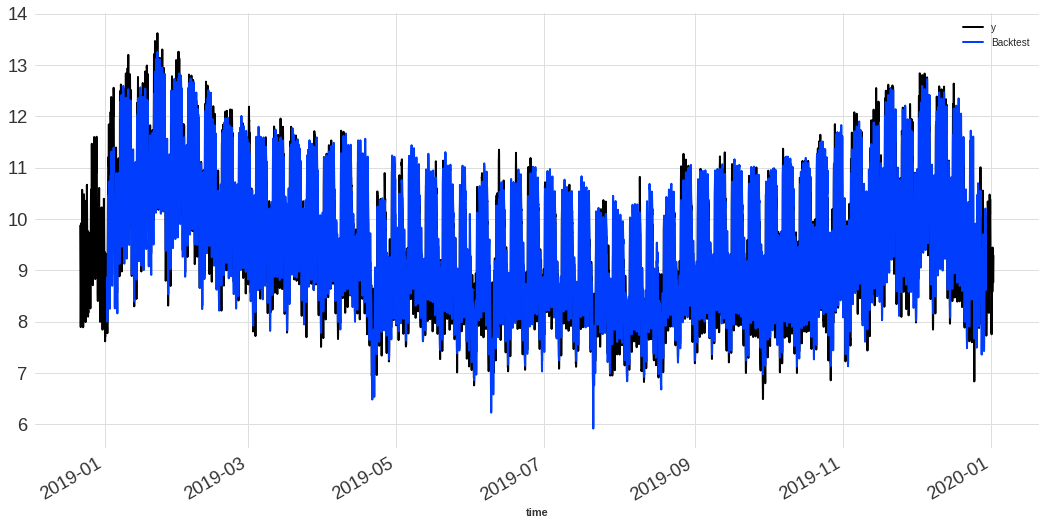

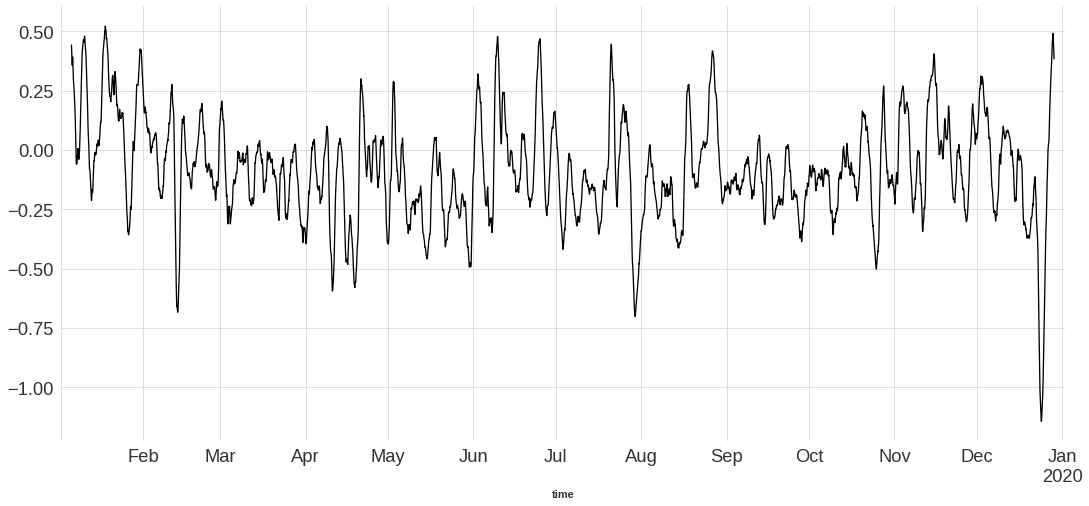

In [137]:
future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

regr_model_cov_336 = RegressionModel(lags=list(range(-336,0)),
                                 lags_future_covariates=list(range(72)))

regr_model_cov_336.fit(input_train, 
                   future_covariates=future)

eval_model(regr_model_cov_168, retrain=False)


In [64]:
# future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

# regr_model_cov = RegressionModel(lags=list(range(-672,0)),
#                                  lags_future_covariates=list(range(72)))

# regr_model_cov.fit(input_train, 
#                    future_covariates=future)

# eval_model(regr_model_cov, retrain=False)


In [65]:
future = TimeSeries.from_dataframe(data, value_cols=['Day_of_week', 'Hour_of_day'])

regr_model_cov_336_calendar = RegressionModel(lags=list(range(-336,0)),
                                 lags_future_covariates=list(range(72)))

regr_model_cov_336_calendar.fit(input_train, 
                   future_covariates=future)

# eval_model(regr_model_cov_timedate, retrain=False)

In [18]:
# future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

# regr_model_cov_ridge = RegressionModel(lags=list(range(-672,0)),
#                                        lags_future_covariates=list(range(72)),
#                                        model=sklearn.linear_model.Ridge(alpha=.5))

# regr_model_cov_ridge.fit(input_train, 
#                          future_covariates=future)

# eval_model(regr_model_cov_ridge, retrain=False)

In [19]:
# future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

# regr_model_cov_lasso = RegressionModel(lags=list(range(-672,0)),
#                                        lags_future_covariates=list(range(72)),
#                                        model=sklearn.linear_model.Lasso(alpha=.01))

# regr_model_cov_lasso.fit(input_train, 
#                          future_covariates=future)

# eval_model(regr_model_cov_lasso, retrain=False)

In [20]:
# future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

# regr_model_cov_lgbm = LightGBMModel(lags=list(range(-672,0)),
#                                lags_future_covariates=list(range(72)),
#                                output_chunk_length=24)

# regr_model_cov_lgbm.fit(input_train, 
#                    future_covariates=future)

# eval_model(regr_model_cov_lgbm, retrain=False)


[LightGBM] [Warning] Unknown parameter: output_chunk_length


In [ ]:
from sklearn.model_selection import GridSearchCV

#Define the parameters
params = {'num_leaves':[50,100], 
          'min_child_samples':[5,10,15],
          'max_depth':[5,10,20],
          'learning_rate':[0.05,0.2],
          'reg_alpha':[0.01,0.1]}

params = {'num_leaves':50, 
          'min_child_samples':5,
          'max_depth':5,
          'learning_rate':0.2,
          'reg_alpha':0.1}



regr_model_cov_lgbm = LightGBMModel(lags=list(range(-336,0)),
                                   lags_future_covariates=list(range(72)),
                                   num_leaves = 50)

regr_model_cov_lgbm.fit(input_train, 
                        future_covariates=future)

#Define the scoring
# reg=GridSearchCV(regr_model_cov_lgbm,params,scoring='neg_median_absolute_error')

regr_model_cov_lgbm.fit(input_train, future_covariates=future)

eval_model(regr_model_cov_lgbm, retrain=False)

# predicted=clf.predict(X_test)


In [ ]:
# We first set aside the first 25% as training series:
input_train, input_test = input_timeseries.split_before(pd.to_datetime('2019-10-15'))

def eval_model(model, past_covariates=None, future_covariates=None, retrain=False):
    
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=pd.to_datetime('2019-10-15'), 
#                                           start=0.33, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=24)
    
    input_timeseries[-len(backtest)-336:].plot()
    backtest.plot(label='Backtest')
    print('Backtest MAPE = {}'.format(mape(input_timeseries, backtest)))
    plt.show()

    error = input_timeseries[-len(backtest):].pd_series() - backtest.pd_series()
    error.rolling(49, center=True).mean().plot()
    plt.show()


In [ ]:
from random import sample, choices
# import random

experiments = 25

# for i in range(experiments):
random.seed(0)
num_leaves = choices([50, 100], k=experiments)
min_child_samples = choices([5,10,15], k=experiments)
max_depth = choices([5,10,20], k=experiments)
learning_rate = choices([0.05,0.2], k=experiments)
reg_alpha = choices([0.01,0.1], k=experiments)

hyperparams = np.vstack((num_leaves, min_child_samples, max_depth, learning_rate, reg_alpha))

for i in range(experiments):
    regr_model_cov_lgbm = LightGBMModel(lags=list(range(-336,0)),
                                        lags_future_covariates=list(range(72)))
#                                         num_leaves = int(hyperparams[0,i]),
#                                         min_child_samples = int(hyperparams[1,i]),
#                                         max_depth = int(hyperparams[2,i]),
#                                         learning_rate = hyperparams[3,i],
#                                         reg_alpha = hyperparams[4,i])
    
    regr_model_cov_lgbm.fit(input_train, future_covariates=future)

    print(i, hyperparams[:,i])
    eval_model(regr_model_cov_lgbm, retrain=False)


In [69]:
future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

regr_lgbm_model_cov_336 = LightGBMModel(lags=list(range(-336,0)),
                               lags_future_covariates=list(range(72)))

regr_lgbm_model_cov_336.fit(input_train, 
                   future_covariates=future)

# eval_model(regr_model_cov_lgbm, retrain=False)


In [ ]:
future = TimeSeries.from_dataframe(data, value_cols=['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays'])

regr_model_cov_lgbm = LightGBMModel(lags=list(range(-672,0)),
                               lags_future_covariates=list(range(72)),
                               output_chunk_length=24)

params = {'num_leaves':[50,100], 
#           'min_child_samples':[5,10,15],
          'max_depth':[5,10,20],
          'learning_rate':[0.05,0.2],
          'reg_alpha':[0.01,0.1]}

print([*params.values()])

regr_model_cov_lgbm.gridsearch(series = input_train, 
                               future_covariates = future,
                               parameters = params,
                               forecast_horizon = 72)

# regr_model_cov_lgbm.fit(input_train, 
#                    future_covariates=future)

# eval_model(regr_model_cov_lgbm, retrain=False)


In [70]:
def get_historical_forecasts(model, model_display_name, future_covs=False, to_retrain=False):

    horizon = 72
    
    if future_covs == False:
        #print(model_display_name, 'no future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, stride=24, verbose=True, 
                                              retrain = to_retrain,
                                              start=pd.to_datetime('2019-01-01'),
                                              last_points_only=False, overlap_end=False)
    else:
        #print(model_display_name, 'with future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, stride=24, verbose=True,
                                              future_covariates=future, overlap_end=False,
                                              retrain = to_retrain,
                                              start=pd.to_datetime('2019-01-01'),
                                              last_points_only=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df.iloc[:-horizon]
    else:
        return res_df


models = {
    'Naive weekly':[naive_model_weekly,False,True],
    'Naive daily': [naive_model_daily,False,True],
    'Theta': [theta_model,False,True],
    'RegLags24':[regr_model_lags_24,False,False],
    'RegLags168':[regr_model_lags_168,False,False],
    'RegLags336':[regr_model_lags_336,False,False],
    'RegCov24':[regr_model_cov_24,True,False],
    'RegCov168':[regr_model_cov_168,True,False],
    'RegCov336':[regr_model_cov_336,True,False],
#     'RegCov336cal':[regr_model_cov_336_calendar,True,False],
#     'RegCovLasso':[regr_model_cov_lasso,True,False],
#     'RegCovRidge':[regr_model_cov_ridge,True,False],
#     'RegCov24':[regr_model_cov_24,True,False],
#     'RegCov168':[regr_model_cov_168,True,False],
    'RegCovLGBM':[regr_lgbm_model_cov_336,True,False]
#     'RegCovTimeDate':[regr_model_cov_timedate,True]
         }

optimization_df = pd.DataFrame()

import time



runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])

for model in models.keys():
    print(model)
    start=time.time()
    optimization_df = optimization_df.append(get_historical_forecasts(model = models[model][0],
                                                                      model_display_name = model,
                                                                      future_covs = models[model][1],
                                                                      to_retrain=models[model][2]))
    end = time.time()
    runtime_df.loc[model,'runtime'] = (end-start)
    

Naive weekly


  0%|          | 0/364 [00:00<?, ?it/s]

Naive daily


  0%|          | 0/364 [00:00<?, ?it/s]

Theta


  0%|          | 0/364 [00:00<?, ?it/s]

RegLags24


  0%|          | 0/364 [00:00<?, ?it/s]

RegLags168


  0%|          | 0/364 [00:00<?, ?it/s]

RegLags336


  0%|          | 0/364 [00:00<?, ?it/s]

RegCov24


  0%|          | 0/361 [00:00<?, ?it/s]

RegCov168


  0%|          | 0/361 [00:00<?, ?it/s]

RegCov336


  0%|          | 0/361 [00:00<?, ?it/s]

RegCovLGBM


  0%|          | 0/361 [00:00<?, ?it/s]

In [71]:
optimization_df

,ts,value,prediction_date,model
0,2019-01-01 00:00:00,8.904500,2019-01-01,Naive weekly
1,2019-01-01 01:00:00,8.510250,2019-01-01,Naive weekly
2,2019-01-01 02:00:00,8.231750,2019-01-01,Naive weekly
3,2019-01-01 03:00:00,8.097000,2019-01-01,Naive weekly
4,2019-01-01 04:00:00,8.097000,2019-01-01,Naive weekly
...,...,...,...,...
67,2019-12-29 19:00:00,9.588695,2019-12-27,RegCovLGBM
68,2019-12-29 20:00:00,9.517837,2019-12-27,RegCovLGBM
69,2019-12-29 21:00:00,9.465861,2019-12-27,RegCovLGBM
70,2019-12-29 22:00:00,9.050263,2019-12-27,RegCovLGBM


In [72]:
# optimization_df[optimization_df.model=='Naive weekly'].value.plot()

In [73]:
runtime_df

,runtime
Naive weekly,2.545781
Naive daily,2.546766
Theta,44.238135
RegLags24,4.236437
RegLags168,4.599998
RegLags336,5.012151
RegCov24,5.490432
RegCov168,5.707233
RegCov336,5.885141
RegCovLGBM,1112.676105


In [74]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index('ts', inplace=True)
fact['model'] = 'Fact'
fact['value'] = data.y.loc[fact.index]
fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact)


# tmp = optimization_df.groupby(['ts','prediction_date']).mean().reset_index()
# tmp['model'] = 'mean_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp = optimization_df.groupby(['ts','prediction_date']).median().reset_index()
# tmp['model'] = 'median_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp = optimization_df.groupby(['ts','prediction_date']).quantile(.05).reset_index()
# tmp['model'] = '5p_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp = optimization_df.groupby(['ts','prediction_date']).quantile(.25).reset_index()
# tmp['model'] = '25p_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp = optimization_df.groupby(['ts','prediction_date']).quantile(.75).reset_index()
# tmp['model'] = '75p_of_all_models'
# optimization_df = optimization_df.append(tmp)

# tmp= optimization_df.groupby(['ts','prediction_date']).quantile(.95).reset_index()
# tmp['model'] = '95p_of_all_models'
# optimization_df = optimization_df.append(tmp)

# optimization_df.set_index('ts', inplace=True)

In [75]:
noisy_biased_1p = fact.copy()
noisy_biased_1p.model = 'noisy_biased_1p'
noisy_biased_1p.value = fact.value + 1

noisy_biased_2p = fact.copy()
noisy_biased_2p.model = 'noisy_biased_2p'
noisy_biased_2p.value = fact.value + 2

noisy_biased_3p = fact.copy()
noisy_biased_3p.model = 'noisy_biased_3p'
noisy_biased_3p.value = fact.value + 3

noisy_biased_4p = fact.copy()
noisy_biased_4p.model = 'noisy_biased_4p'
noisy_biased_4p.value = fact.value + 4

noisy_biased_1n = fact.copy()
noisy_biased_1n.model = 'noisy_biased_1n'
noisy_biased_1n.value = fact.value - 1

noisy_biased_2n = fact.copy()
noisy_biased_2n.model = 'noisy_biased_2n'
noisy_biased_2n.value = fact.value - 2

noisy_biased_3n = fact.copy()
noisy_biased_3n.model = 'noisy_biased_3n'
noisy_biased_3n.value = fact.value - 3

noisy_biased_4n = fact.copy()
noisy_biased_4n.model = 'noisy_biased_4n'
noisy_biased_4n.value = fact.value - 4

optimization_df = optimization_df.append(noisy_biased_1p)
optimization_df = optimization_df.append(noisy_biased_2p)
optimization_df = optimization_df.append(noisy_biased_3p)
optimization_df = optimization_df.append(noisy_biased_4p)
optimization_df = optimization_df.append(noisy_biased_1n)
optimization_df = optimization_df.append(noisy_biased_2n)
optimization_df = optimization_df.append(noisy_biased_3n)
optimization_df = optimization_df.append(noisy_biased_4n)


In [76]:
np.random.seed(42)

noisy_normal_0u_1s = fact.copy()
noisy_normal_0u_1s.model = 'noisy_normal_0u_1s'
noisy_normal_0u_1s.value = fact.value + np.random.uniform(-1,1,len(fact))

noisy_normal_0u_2s = fact.copy()
noisy_normal_0u_2s.model = 'noisy_normal_0u_2s'
noisy_normal_0u_2s.value = fact.value + np.random.uniform(-2,2,len(fact))

noisy_normal_0u_3s = fact.copy()
noisy_normal_0u_3s.model = 'noisy_normal_0u_3s'
noisy_normal_0u_3s.value = fact.value + np.random.uniform(-3,3,len(fact))

noisy_normal_0u_4s = fact.copy()
noisy_normal_0u_4s.model = 'noisy_normal_0u_4s'
noisy_normal_0u_4s.value = fact.value + np.random.uniform(-4,4,len(fact))

optimization_df = optimization_df.append(noisy_normal_0u_1s)
optimization_df = optimization_df.append(noisy_normal_0u_2s)
optimization_df = optimization_df.append(noisy_normal_0u_3s)
optimization_df = optimization_df.append(noisy_normal_0u_4s)


In [77]:
np.random.seed(42)

noisy_signal_dependent_10 = fact.copy()
noisy_signal_dependent_10.model = 'noisy_signal_dependent_10'
noisy_signal_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_20 = fact.copy()
noisy_signal_dependent_20.model = 'noisy_signal_dependent_20'
noisy_signal_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_30 = fact.copy()
noisy_signal_dependent_30.model = 'noisy_signal_dependent_30'
noisy_signal_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_40 = fact.copy()
noisy_signal_dependent_40.model = 'noisy_signal_dependent_40'
noisy_signal_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))

optimization_df = optimization_df.append(noisy_signal_dependent_10)
optimization_df = optimization_df.append(noisy_signal_dependent_20)
optimization_df = optimization_df.append(noisy_signal_dependent_30)
optimization_df = optimization_df.append(noisy_signal_dependent_40)

In [78]:
fact['time_since_prediction'] = (fact.ts - fact.prediction_date) / np.timedelta64(1, 'h')
fact

,ts,value,prediction_date,model,time_since_prediction
0,2019-01-01 00:00:00,8.542750,2019-01-01,Fact,0.0
1,2019-01-01 01:00:00,8.026333,2019-01-01,Fact,1.0
2,2019-01-01 02:00:00,7.823250,2019-01-01,Fact,2.0
3,2019-01-01 03:00:00,7.636250,2019-01-01,Fact,3.0
4,2019-01-01 04:00:00,7.616750,2019-01-01,Fact,4.0
...,...,...,...,...,...
26131,2019-12-31 19:00:00,9.368500,2019-12-29,Fact,67.0
26132,2019-12-31 20:00:00,9.091500,2019-12-29,Fact,68.0
26133,2019-12-31 21:00:00,9.340500,2019-12-29,Fact,69.0
26134,2019-12-31 22:00:00,9.431667,2019-12-29,Fact,70.0


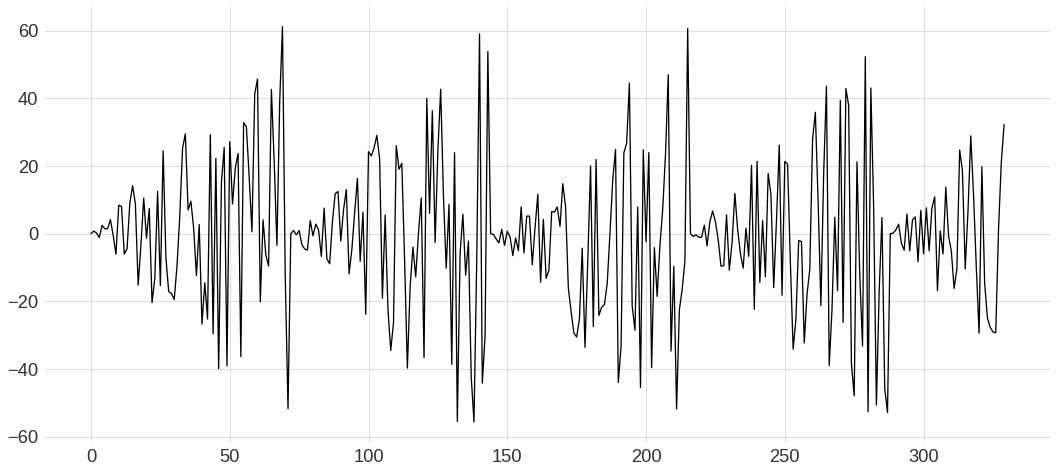

In [79]:
plt.plot(np.random.uniform(-fact.time_since_prediction,fact.time_since_prediction,len(fact))[0:330])

In [80]:
np.random.seed(42)

noisy_horizon_dependent_10 = fact.copy()
noisy_horizon_dependent_10.model = 'noisy_horizon_dependent_10'
noisy_horizon_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_20 = fact.copy()
noisy_horizon_dependent_20.model = 'noisy_horizon_dependent_20'
noisy_horizon_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_30 = fact.copy()
noisy_horizon_dependent_30.model = 'noisy_horizon_dependent_30'
noisy_horizon_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_40 = fact.copy()
noisy_horizon_dependent_40.model = 'noisy_horizon_dependent_40'
noisy_horizon_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))

optimization_df = optimization_df.append(noisy_horizon_dependent_10)
optimization_df = optimization_df.append(noisy_horizon_dependent_20)
optimization_df = optimization_df.append(noisy_horizon_dependent_30)
optimization_df = optimization_df.append(noisy_horizon_dependent_40)

In [81]:
optimization_df

,ts,value,prediction_date,model,time_since_prediction
0,2019-01-01 00:00:00,8.904500,2019-01-01,Naive weekly,NaN
1,2019-01-01 01:00:00,8.510250,2019-01-01,Naive weekly,NaN
2,2019-01-01 02:00:00,8.231750,2019-01-01,Naive weekly,NaN
3,2019-01-01 03:00:00,8.097000,2019-01-01,Naive weekly,NaN
4,2019-01-01 04:00:00,8.097000,2019-01-01,Naive weekly,NaN
...,...,...,...,...,...
26131,2019-12-31 19:00:00,13.073042,2019-12-29,noisy_horizon_dependent_40,67.0
26132,2019-12-31 20:00:00,11.326277,2019-12-29,noisy_horizon_dependent_40,68.0
26133,2019-12-31 21:00:00,12.438768,2019-12-29,noisy_horizon_dependent_40,69.0
26134,2019-12-31 22:00:00,6.806628,2019-12-29,noisy_horizon_dependent_40,70.0


In [ ]:
alt.data_transformers.disable_max_rows()

alt.Chart(optimization_df.reset_index()).mark_line().encode(
    x='ts:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('prediction_date:N', legend=None),
    row='model:N'
).properties(width=600, height=150).interactive()


# Optimizer to choose from several predictions

Predictions are ready. Now we are creating a child class for Electricity Peak Case. 
We need the child class to pass there task-specific cost functions and other constant values like PEAK_POWER_LIMIT, BATTERY_CHARGE, BATTERY_CAPACITY end so on

In [82]:
# !pip install pulp
import pulp

In [138]:
def formulate_optimization_problem(price, demand, inverterCapacity, batteryCapacity, batteryInitialCharge, peakPowerLimit):
    
    # Create a list of time points when decision needs to be taken
    time_points=[str(i) for i in range(len(demand))]
    
    # Create dictionary holding prices at the time points
    price_dict = dict(zip(time_points, price))

    # Create a variable for every point in time
    time_point_vars=pulp.LpVariable.dict("solution", time_points, -inverterCapacity, inverterCapacity)

    # Define the problem as minimization
    prob = pulp.LpProblem("VOF", pulp.LpMinimize)
    prob += pulp.lpSum([time_point_vars[i]*price_dict[i] for i in time_points])
    
    # Create a variable for every point in time
    demand_vars=dict(zip(time_points, demand))

    # Add constraints
    prob += time_point_vars['0'] == batteryInitialCharge
    for j in range(len(time_points)):
        # At every point in time the cumulated charge/discharge needs to be within bounds
        prob += pulp.lpSum([time_point_vars[i] for i in time_points[:j+1]]) <= batteryCapacity
        prob += pulp.lpSum([time_point_vars[i] for i in time_points[:j+1]]) >= 0
        prob += time_point_vars[str(j)] + demand_vars[str(j)] >= 0
        prob += time_point_vars[str(j)] + demand_vars[str(j)] <= peakPowerLimit
        
#     print(prob)
    return prob
    

In [139]:
def evaluate_optimization_problem(price, demand, peakPowerLimit):
    peakViolations = 0    
    peakViolations += np.sum((solution+actualDemand.values)[0:24] - peakPowerLimit)
    
    print(peakViolations)

In [140]:
optimization_df.model.unique()

array(['Naive weekly', 'Naive daily', 'Theta', 'RegLags24', 'RegLags168',
       'RegLags336', 'RegCov24', 'RegCov168', 'RegCov336', 'RegCovLGBM',
       'Fact', 'noisy_biased_1p', 'noisy_biased_2p', 'noisy_biased_3p',
       'noisy_biased_4p', 'noisy_biased_1n', 'noisy_biased_2n',
       'noisy_biased_3n', 'noisy_biased_4n', 'noisy_normal_0u_1s',
       'noisy_normal_0u_2s', 'noisy_normal_0u_3s', 'noisy_normal_0u_4s',
       'noisy_signal_dependent_10', 'noisy_signal_dependent_20',
       'noisy_signal_dependent_30', 'noisy_signal_dependent_40',
       'noisy_horizon_dependent_10', 'noisy_horizon_dependent_20',
       'noisy_horizon_dependent_30', 'noisy_horizon_dependent_40'],
      dtype=object)

In [220]:
batteryCapacity = 16.0 #kWh
inverterCapacity = 8.0 #kW
peakPowerLimit = 12.5 # kW

total_steps = optimization_df.prediction_date.unique()
# battery_ch = batteryInitialCharge
# model = 'Naive weekly'
# model = 'RegressionModelCov'
actualModel = 'Fact'
peakViolations = np.zeros(1+len(optimization_df.model.unique()))
predictionError = np.zeros(1+len(optimization_df.model.unique()))
predictionErrorFirstDay = np.zeros(1+len(optimization_df.model.unique()))
energyCosts = np.zeros(1+len(optimization_df.model.unique()))
nDays = 100

ctr = 0
for model in optimization_df.model.unique():
# for model in ['Naive daily']:
    
    print(model)
    peakViolations[ctr] = 0
    batteryInitialCharge = 0 #kWh

    for step in total_steps[0:nDays]:
#         print(step)

        demand = optimization_df.loc[(optimization_df.prediction_date==step)&(optimization_df.model==model),'value']
        actualDemand = optimization_df.loc[(optimization_df.prediction_date==step)&(optimization_df.model==actualModel),'value']

        price = np.ones(len(demand))
#         price = [1,1,1,1,1,1,1,2,2,2,1,1,1,2,2,1,1,1,2,2,2,2,1,1] * 3

        opt_problem = formulate_optimization_problem(price, demand, inverterCapacity, batteryCapacity, batteryInitialCharge, peakPowerLimit)
        opt_problem.solve()

#         print("Found minimum",opt_problem.objective.value())

        solution_dict = {}
        for v in opt_problem.variables():
            solution_dict[int(v.name.replace("solution_",""))] = v.varValue
        # Now convert solution dictionary to a time-sorted list
        solution=[]
        for i in sorted (solution_dict) :
            solution.append(solution_dict[i])

#         batteryInitialCharge = np.cumsum(solution)[23]
#         print(np.cumsum(solution)[23])
#         plt.plot(price)
#         plt.plot(solution,label='Solution')
#         plt.plot(np.cumsum(solution))
#         plt.plot(demand.values,label='Predicted demand')
#         plt.plot(actualDemand.values,label='Actual demand')
#         plt.plot(solution+demand.values,label='Sol+Pred.Demand')
#         plt.plot(solution+actualDemand.values,label='Sol+Act.Demand')
#         plt.legend()
#         plt.ylim(-10,20)
#         plt.show()

#         peakViolations[ctr] += np.sum((solution+actualDemand.values)[0:24] - peakPowerLimit)
        excessDemand = (solution+actualDemand.values)[0:24]-peakPowerLimit
        peakViolations[ctr] += np.sum(excessDemand[excessDemand>0])
        predictionError[ctr] += np.nanmean(np.abs(demand.values-actualDemand.values))
        predictionErrorFirstDay[ctr] += np.nanmean(np.abs(demand.values[0:24]-actualDemand.values[0:24]))
        energyCosts[ctr] += np.sum(np.array(solution[0:24]) * np.array(price[0:24]))
    
#     plt.plot(demand.values)
#     plt.plot(actualDemand.values)
#     plt.show()
    
    print(predictionError[ctr], predictionErrorFirstDay[ctr], peakViolations[ctr], energyCosts[ctr])
    ctr += 1


Naive weekly
47.47070659722224 47.52942881944446 338.73495821400024 1343.8501670152998
Naive daily
86.48289699074074 63.574250000000006 405.66054219696656 1338.8472504852998
Theta
47.71346460716977 43.65558395197308 186.67968558166672 1280.8707958849002
RegLags24
79.79111793820739 58.61260382407694 515.9848398358336 1442.5100778434
RegLags168
43.45385896130205 36.87790031970456 323.7011674533666 1357.8365104980999
RegLags336
41.50593240763588 33.09041739534518 302.90157529727 1367.9875009893403
RegCov24
36.815994458233845 32.00948317972818 231.6547155302333 1361.74430019419
RegCov168
29.900010924727827 25.171631011962887 218.02217573370004 1365.6369035466994
RegCov336
30.408015701859078 25.23827519904243 229.2482829732633 1381.03518679293
RegCovLGBM
31.867654204564428 27.348914556480743 246.93241048043356 1374.2740418745998
Fact
0.0 0.0 4.094700084777969e-06 1343.8501671152999
noisy_biased_1p
100.0 100.0 278.5456672663333 942.9091677097001
noisy_biased_2p
200.0 200.0 1949.7334605 1568.

In [221]:
for step in total_steps[0:30]:

    actualDemand = optimization_df.loc[(optimization_df.prediction_date==step)&(optimization_df.model==actualModel),'value']
    excessDemand = (actualDemand.values)-peakPowerLimit
    peakViolations[ctr] += np.sum(excessDemand[excessDemand>0])
    predictionError[ctr] = 0
    predictionErrorFirstDay[ctr] = 0


In [222]:
peakViolations = peakViolations / nDays
predictionError = predictionError / nDays
predictionErrorFirstDay = predictionErrorFirstDay / nDays
energyCosts = energyCosts / nDays


In [223]:
peakViolations
energyCosts = (energyCosts) / 3

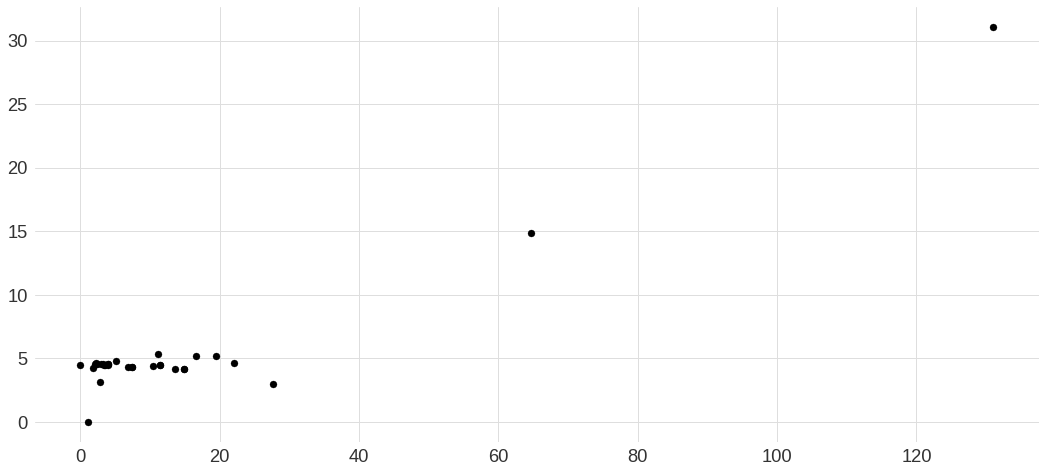

In [224]:
plt.scatter(peakViolations, energyCosts)


In [225]:
model_names = optimization_df.model.unique()
model_names = np.hstack((model_names, ['No control']))


In [226]:
results_df = pd.DataFrame(np.array([model_names, predictionErrorFirstDay, peakViolations, energyCosts]).T).iloc[:-1,:]
results_df.columns = ['Model', 'Forecast error', 'Peak violations', 'Energy costs']
results_df


,Model,Forecast error,Peak violations,Energy costs
0,Naive weekly,0.475294,3.38735,4.479501
1,Naive daily,0.635743,4.056605,4.462824
2,Theta,0.436556,1.866797,4.269569
3,RegLags24,0.586126,5.159848,4.808367
4,RegLags168,0.368779,3.237012,4.526122
5,RegLags336,0.330904,3.029016,4.559958
6,RegCov24,0.320095,2.316547,4.539148
7,RegCov168,0.251716,2.180222,4.552123
8,RegCov336,0.252383,2.292483,4.603451
9,RegCovLGBM,0.273489,2.469324,4.580913


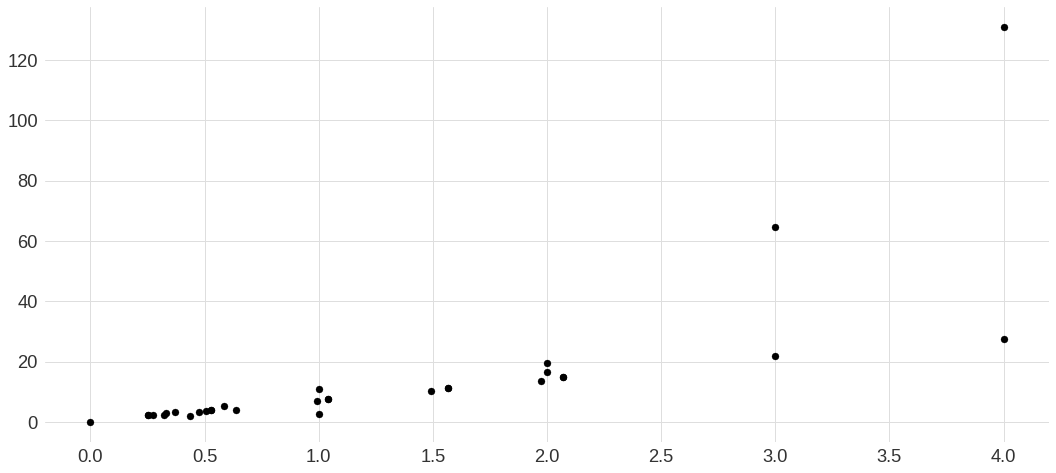

In [227]:
plt.scatter(results_df['Forecast error'], results_df['Peak violations'])
# plt.ylim(0,20)

In [228]:
results_df.to_csv('energy-results_df_B16_I8_p12.5.csv')

In [39]:
# results_df = pd.DataFrame(np.array([model_names,8 predictionErrorFirstDay, peakViolations]).T)
# results_df.columns = ['Model', 'Forecast error', 'Downstream costs']
# results_df


In [159]:
results_df['Model type'] = (np.zeros(len(results_df))).astype(int)
results_df['Model type'][0:2] = 'Persistence'
results_df['Model type'][2:10] = 'Actual'
results_df['Model type'][10] = 'Fact'
results_df['Model type'][11:] = 'Simulated'
results_df

,Model,Forecast error,Peak violations,Energy costs,Model type
0,Naive weekly,0.475294,4.887312,1.937598,Persistence
1,Naive daily,0.635743,5.186781,1.948839,Persistence
2,Theta,0.436556,5.884121,1.913438,Actual
3,RegLags24,0.586126,5.387863,2.125604,Actual
4,RegLags168,0.368779,4.386941,2.059118,Actual
5,RegLags336,0.330904,4.565929,2.115596,Actual
6,RegCov24,0.320095,3.664189,2.051114,Actual
7,RegCov168,0.251716,3.325857,2.055984,Actual
8,RegCov336,0.252383,3.386533,2.056866,Actual
9,RegCovLGBM,0.273489,3.864827,2.11464,Actual


In [160]:
chart = alt.Chart(results_df).mark_circle(size=500, clip=True).encode(
    x=alt.Y('Forecast error:Q', scale=alt.Scale(domain=[0, 1.2])),
    y = alt.Y('Peak violations:Q', scale=alt.Scale(domain=[0, 5])),
#     y=alt.Y('Downstream costs:Q'),
#     size=alt.Size('Energy costs'),
#     color=alt.Color('Model:N'),
    color=alt.Color('Model type:N'),
    tooltip = ['Model:N','Forecast error:Q','Energy costs:Q']
).properties(width=800, height=600)

chart2 = alt.Chart(results_df).mark_circle(size=500, clip=True).encode(
    x=alt.Y('Forecast error:Q', scale=alt.Scale(domain=[0, 1.2])),
    y = alt.Y('Peak violations:Q', scale=alt.Scale(domain=[0, 5])),
#     size=alt.Size('Energy costs'),
#     color=alt.Color('Model:N'),
    color=alt.Color('Model type:N'),
    tooltip = ['Model:N','Forecast error:Q','Energy costs:Q']
).properties(width=800, height=600)

(chart + chart2 + chart.transform_loess('Forecast error', 'Peak violations', bandwidth=.99).mark_line()).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=18,
labelFontSize=15
) 

# chart +chart2+ chart.transform_regression('Forecast error', 'Downstream costs', method='poly', order=3).mark_line()


alt.LayerChart(...)

In [41]:
chart = alt.Chart(results_df).mark_circle(size=500).encode(
    x='Forecast error:Q',
    y = alt.Y('Peak violations:Q'), # scale=alt.Scale(domain=[0, 160])),
#     y=alt.Y('Downstream costs:Q'),
#     size=alt.Size('Energy costs'),
    color=alt.Color('Model:N'),
    tooltip = ['Model:N','Forecast error:Q','Downstream costs:Q']
).properties(width=800, height=600)

chart2 = alt.Chart(results_df).mark_circle(size=500).encode(
    x='Forecast error:Q',
    y=alt.Y('Peak violations:Q'),
#     size=alt.Size('Energy costs'),
    color=alt.Color('Model:N'),
    tooltip = ['Model:N','Forecast error:Q','Downstream costs:Q']
).properties(width=800, height=600)

(chart + chart2 + chart.transform_loess('Forecast error', 'Peak violations', bandwidth=.99).mark_line()).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=18,
labelFontSize=15
) 

# chart +chart2+ chart.transform_regression('Forecast error', 'Downstream costs', method='poly', order=3).mark_line()


alt.LayerChart(...)

In [42]:
np.abs(demand-actualDemand)

2088   NaN
2089   NaN
2090   NaN
2091   NaN
2092   NaN
2093   NaN
2094   NaN
2095   NaN
2096   NaN
2097   NaN
2098   NaN
2099   NaN
2100   NaN
2101   NaN
2102   NaN
2103   NaN
2104   NaN
2105   NaN
2106   NaN
2107   NaN
2108   NaN
2109   NaN
2110   NaN
2111   NaN
2112   NaN
2113   NaN
2114   NaN
2115   NaN
2116   NaN
2117   NaN
2118   NaN
2119   NaN
2120   NaN
2121   NaN
2122   NaN
2123   NaN
2124   NaN
2125   NaN
2126   NaN
2127   NaN
2128   NaN
2129   NaN
2130   NaN
2131   NaN
2132   NaN
2133   NaN
2134   NaN
2135   NaN
2136   NaN
2137   NaN
2138   NaN
2139   NaN
2140   NaN
2141   NaN
2142   NaN
2143   NaN
2144   NaN
2145   NaN
2146   NaN
2147   NaN
2148   NaN
2149   NaN
2150   NaN
2151   NaN
2152   NaN
2153   NaN
2154   NaN
2155   NaN
2156   NaN
2157   NaN
2158   NaN
2159   NaN
7128   NaN
7129   NaN
7130   NaN
7131   NaN
7132   NaN
7133   NaN
7134   NaN
7135   NaN
7136   NaN
7137   NaN
7138   NaN
7139   NaN
7140   NaN
7141   NaN
7142   NaN
7143   NaN
7144   NaN
7145   NaN
7146   NaN

In [43]:
# Create a list of time points when decision needs to be taken
control_horizon = 72
control_update_step = 24
time_points=[str(i) for i in range(control_horizon)]

# Create dictionary holding prices at the time points
price_dict = dict(zip(time_points, price[0:control_horizon]))

# Create a variable for every point in time
time_point_vars=pulp.LpVariable.dict("solution",time_points,-inverterCapacity,inverterCapacity)

# Define the problem as minimization
prob = pulp.LpProblem("VOF", pulp.LpMinimize)
prob += pulp.lpSum([time_point_vars[i]*price_dict[i] for i in time_points])

# Add constraints
prob += time_point_vars['0'] == 20
for j in range(len(time_points)):
    # At every point in time the cumulated charge/discharge needs to be within bounds
    prob += pulp.lpSum([time_point_vars[i] for i in time_points[:j+1]]) <= batteryCapacity
    prob += pulp.lpSum([time_point_vars[i] for i in time_points[:j+1]]) >= 0
    prob += time_point_vars[str(j)] + demand_vars[str(j)] >= 0
    prob += time_point_vars[str(j)] + demand_vars[str(j)] <= 80


NameError: name 'demand_vars' is not defined

In [ ]:
def calculate_optimal_decision(self, model):
    EVALUATE = False
    TIME_HORIZON = 72#168
    DECISION_TIMESTEP = 24
    PEAK_POWER_LIMIT = 11
    BATTERY_CHARGE = 0
    BATTERY_CAPACITY = 1000
    BATTERY_EFFICIENCY = .99
    INVERTER_CAPACITY = 80
    

In [ ]:
# Solve
prob.solve()
# Print result
print("Found minimum",prob.objective.value())
solution_dict = {}
for v in prob.variables():
    solution_dict[int(v.name.replace("solution_",""))] = v.varValue
# Now convert solution dictionary to a time-sorted list
solution=[]
for i in sorted (solution_dict) :
    solution.append(solution_dict[i])

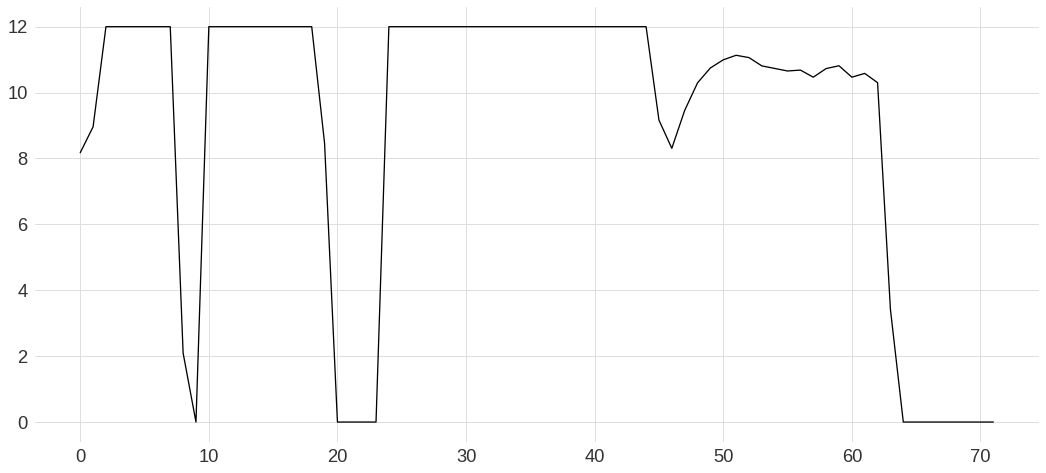

In [78]:
plt.plot(solution+actualDemand.values)

In [70]:
optimization_df.model.unique()

array(['Naive weekly', 'Naive daily', 'RegressionModelCov', 'Fact',
       'noisy_biased_1p', 'noisy_biased_2p', 'noisy_biased_3p',
       'noisy_biased_4p', 'noisy_biased_1n', 'noisy_biased_2n',
       'noisy_biased_3n', 'noisy_biased_4n'], dtype=object)

In [97]:
np.sum((solution+actualDemand.values)[0:24] - peakPowerLimit)

-80.30941681766667

In [99]:
peakViolations

array([-2.38543333e+01, -1.84165833e+01,  1.71947920e-01,  4.38809210e-01,
        4.71879503e-01, -2.09972340e-01, -2.93720937e-01, -2.66795794e+00,
       -3.27596032e+01, -7.48815988e+01, -2.02270510e+00, -4.21464267e-01,
       -4.57391200e-01,  4.59642333e-02, -3.49436500e-01, -3.95372867e-01,
       -6.21076500e-01, -5.96502233e-01, -5.97171867e-01, -8.13607522e+00,
       -3.63755960e+01, -3.59905404e+01, -3.56069990e+01, -2.30813377e+01])

In [ ]:
# Print result
print("Found minimum",opt_problem.objective.value())
solution_dict = {}
for v in opt_problem.variables():
    solution_dict[int(v.name.replace("solution_",""))] = v.varValue
# Now convert solution dictionary to a time-sorted list
solution=[]
for i in sorted (solution_dict) :
    solution.append(solution_dict[i])
# visualizeResults(solution)
plt.plot(solution)


In [ ]:
def calculate_optimal_decision(model):
        
    print(model)

    total_steps = optimization_df.prediction_date.unique()

#     recommendation = np.array([])
#     recommendation = pd.Series()
    battery_ch = self.BATTERY_CHARGE

    for step in total_steps:
        print(step)
#         par = ng.p.Array(shape=(self.TIME_HORIZON,)).set_bounds(lower=-self.INVERTER_CAPACITY, upper=self.INVERTER_CAPACITY)
#         instru = ng.p.Instrumentation(par,battery_ch)
#         optimizer = ng.optimizers.CMA(parametrization=instru, budget=2500)
        
        

        try:
            self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value']
        except:
            #print(self.optimal_decisions_df.shape)
            print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


        step_recommendation = optimizer.minimize(self.cost_function)

        #because step_recommendation returns a tuple, we need to access element with index [0][0]:           
        #recommendation = np.append(recommendation,step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])

        recommendation = recommendation.append(pd.Series(data=step_recommendation[0][0].value[0:self.DECISION_TIMESTEP],
                                                         index=np.array(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'].iloc[0:self.DECISION_TIMESTEP].index)))
        battery_ch += sum(step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])

    return pd.Series(name=model, data=recommendation)


def select_value_optimal_model(self,models,return_predictions=False):

    random.seed(42)

    #self.optimal_decisions_df = pd.DataFrame(index=(self.x.index),columns=self.x.columns).iloc[:-self.TIME_HORIZON]

    #parallel_optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(col) for col in range(len(self.optimal_decisions_df.columns))))

    self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))


    #for i in parallel_optimal_decision_result:
    #    self.optimal_decisions_df.iloc[:,i.name] = i.values

    return self.optimal_decision_result#self.optimal_decisions_df

In [53]:
class OptimalDecisionMakersElectricityPeak(optimizer.OptimalDecisionMakers):
    
    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 72#168
        self.DECISION_TIMESTEP = 24
        self.PEAK_POWER_LIMIT = 11
        self.BATTERY_CHARGE = 0
        self.BATTERY_CAPACITY = 1000
        self.BATTERY_EFFICIENCY = .99
        self.INVERTER_CAPACITY = 80
        
    def cost_function(self,solution,battery_charge):
        #print(battery_charge)
        cumsum = np.cumsum(solution) + battery_charge

        #battery capacity penalty:
        violations_battery = (np.sum(np.where(cumsum>self.BATTERY_CAPACITY)) + np.sum(np.where(cumsum<0))) * 10000
        
        
        #penalty for putting electricity back to the grid
        if self.EVALUATE:
            grid_load = (self.data.loc[self.data.model==target,'value']+solution).values
        else:
            #print(self.candidate.shape)
            grid_load = (self.candidate+solution).values
        
        violations_demand = -np.sum(grid_load[np.where(grid_load<0)]) * 10000

        #penlty for high peak in load
        margin = (self.PEAK_POWER_LIMIT - grid_load)
        violations_peak = -np.sum(margin[np.where(margin < 0)]) * 10000

        #penalty for battery losses
        battery_usage = (1 - self.BATTERY_EFFICIENCY) * np.sum(np.abs(solution)) * 1000

        total_cost = violations_battery + violations_demand + violations_peak + battery_usage
        return total_cost
    
        
    def calculate_optimal_decision(self, model):
        
        print(model)

        total_steps = self.data.prediction_date.unique()

        #recommendation = np.array([])
        recommendation = pd.Series()
        battery_ch = self.BATTERY_CHARGE

        for step in total_steps:
            print(step)
            par = ng.p.Array(shape=(self.TIME_HORIZON,)).set_bounds(lower=-self.INVERTER_CAPACITY, upper=self.INVERTER_CAPACITY)
            instru = ng.p.Instrumentation(par,battery_ch)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=2500)

            try:
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value']
            except:
                #print(self.optimal_decisions_df.shape)
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


            step_recommendation = optimizer.minimize(self.cost_function)

            #because step_recommendation returns a tuple, we need to access element with index [0][0]:           
            #recommendation = np.append(recommendation,step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])
            
            recommendation = recommendation.append(pd.Series(data=step_recommendation[0][0].value[0:self.DECISION_TIMESTEP],
                                                             index=np.array(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'].iloc[0:self.DECISION_TIMESTEP].index)))
            battery_ch += sum(step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])
        
        return pd.Series(name=model, data=recommendation)
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
        
        #self.optimal_decisions_df = pd.DataFrame(index=(self.x.index),columns=self.x.columns).iloc[:-self.TIME_HORIZON]
        
        #parallel_optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(col) for col in range(len(self.optimal_decisions_df.columns))))
        
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

                
        #for i in parallel_optimal_decision_result:
        #    self.optimal_decisions_df.iloc[:,i.name] = i.values

        return self.optimal_decision_result#self.optimal_decisions_df
    
    def evaluate(self):
        
        evaluation_df = pd.DataFrame(index=range(len(self.optimal_decision_result)), columns=['model','cost_evaluation','error_evaluation'])
        for i in range(len(self.optimal_decision_result)):  
            evaluation_df.loc[i,'model'] = self.optimal_decision_result[i].name
            evaluation_df.loc[i,'cost_evaluation'] = (self.optimal_decision_result[i]+self.data.loc[self.data.model=='Fact','value'])[(self.optimal_decision_result[i]+self.data.loc[self.data.model=='Fact','value'])>self.PEAK_POWER_LIMIT].sum()
            evaluation_df.loc[i,'error_evaluation'] = np.mean(np.abs(self.data.loc[self.data.model=='Fact','value'] - self.data.loc[self.data.model==self.optimal_decision_result[i].name,'value']))
            #print(evaluation_df)
            
        return evaluation_df
    
    def evaluate_no_control_case(self):
        evaluation_df = pd.DataFrame(index=[0])#index=range(len(self.optimal_decision_result)), columns=['model','cost_evaluation','error_evaluation'])
        evaluation_df['model'] = 'Fact (no control)'
        evaluation_df['cost_evaluation'] = (self.data.loc[self.data.model=='Fact','value'])[(self.data.loc[self.data.model=='Fact','value'])>self.PEAK_POWER_LIMIT].sum()
        evaluation_df['error_evaluation'] = 0
        
        return evaluation_df
        
    def select_value_optimal_hyperparameters():
        return
    

## Now just creating an oblect of this child class using optimization_df from the previous steps

In [54]:
odm = OptimalDecisionMakersElectricityPeak(optimization_df,'Fact')

In [55]:
#odm.calculate_optimal_decision('RegressionModelCov')
#optimization_df.model.value_counts()

## Running optimization to select the optimal model

In [56]:
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())
#sol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed: 20.4min remaining: 102.2min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed: 20.5min remaining: 61.5min
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed: 20.6min remaining: 41.1min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed: 20.6min remaining: 28.8min
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed: 20.6min remaining: 20.6min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed: 20.6min remaining: 14.7min
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed: 20.6min remaining: 10.3min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 20.7min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 20.7min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 20.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elaps

In [45]:
# for col in range(len(sol)):
#     plt.plot(sol[col].dropna()+data.y, label=sol[col].name)

# #plt.plot(tmp.y.loc['2019-03-02':'2019-04-01'], label='Fact', lw=3)
# plt.legend()

## Evaluation returns outputs of cost function for each of the models:

,model,cost_evaluation,error_evaluation
0,Naive weekly,19649.829007,1.001735
1,Naive daily,17750.980609,1.002548
2,RegressionModelCov,18552.032846,0.967588
3,Fact,9154.648903,0.0
4,noisy_biased_1p,10684.213145,1.0
5,noisy_biased_2p,19783.43773,2.0
6,noisy_biased_3p,30755.075298,3.0
7,noisy_biased_4p,38609.010621,4.0
8,noisy_biased_1n,26236.386965,1.0
9,noisy_biased_2n,25585.772863,2.0


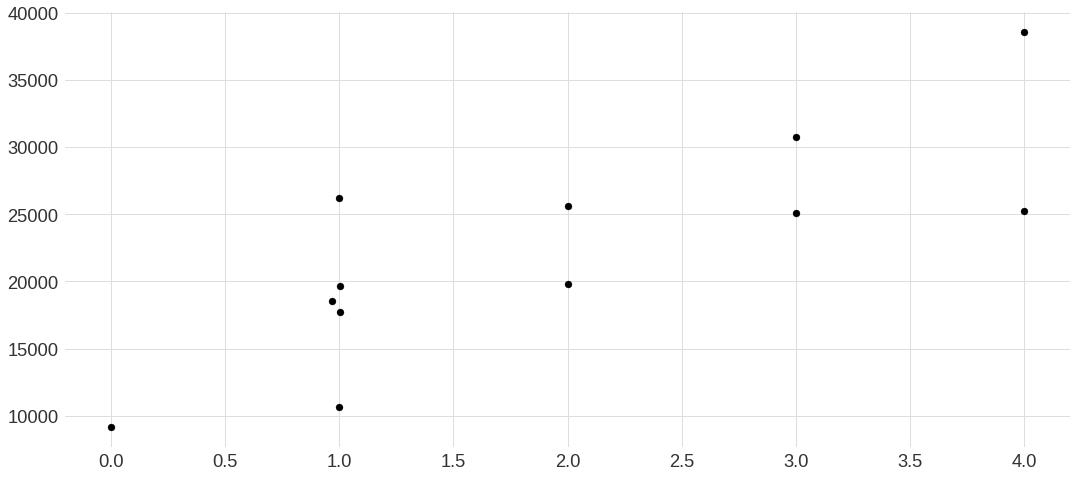

In [57]:
EVALUATE = True
results = odm.evaluate()
#plt.scatter(results[0],results[1])

plt.scatter(results['error_evaluation'],results['cost_evaluation'])

# results = results.append(odm.evaluate_no_control_case(), ignore_index=True)
# results = results.join(runtime_df, how='left', on='model')

results

In [58]:
'''line = pd.DataFrame({
    'Goals Conceded': [0, 2],
    'Goals': [0, 2],
})

line_plot = alt.Chart(line).mark_line(color= 'red').encode(
    x= 'Goals Conceded',
    y= 'Goals'.
)

line_plot'''

"line = pd.DataFrame({\n    'Goals Conceded': [0, 2],\n    'Goals': [0, 2],\n})\n\nline_plot = alt.Chart(line).mark_line(color= 'red').encode(\n    x= 'Goals Conceded',\n    y= 'Goals'.\n)\n\nline_plot"

In [59]:
chart = alt.Chart(results.loc[results.model != 'Fact (no control)']).mark_circle(size=500).encode(
    x='error_evaluation:Q',
    y=alt.Y('cost_evaluation:Q'),
    color=alt.Color('model:N'),
    tooltip = ['model:N','error_evaluation:Q','cost_evaluation:Q']
).properties(width=600, height=600)

chart2 = alt.Chart(results.loc[results.model == 'Fact (no control)']).mark_circle(size=500).encode(
    x='error_evaluation:Q',
    y=alt.Y('cost_evaluation:Q'),
    color=alt.Color('model:N'),
    tooltip = ['model:N','error_evaluation:Q','cost_evaluation:Q']
).properties(width=600, height=600)


chart +chart2+ chart.transform_regression('error_evaluation', 'cost_evaluation', method='poly', order=4).mark_line()

alt.LayerChart(...)

In [ ]:
# results.to_csv('results/VOF_20m_90d_h120.csv')